I'm using this NB to generate synthetic data to be used for my RAG

In [6]:
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from typing import  TypedDict, List
from langchain_google_vertexai import ChatVertexAI
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display_markdown


In [22]:
plan_prompt = """You are an expert technical writer and a machine repair specialist. Your task is to generate detailed 15 page or more,  documentation for repairing a fictional machine named : X3000 TurboFixer.
Generate the documentation for the user's request and the initial outline."""

draft_prompt = """
You are an expert technical writer and a machine repair specialist. Your task is to generate detailed 15 page documentation for repairing and using X3000 TurboFixer machine.
Generate the documentation for the user's request and the initial outline.
If the user provides critique,or sections to be added,  respond with a revised version of your previous attempts.
"""


In [8]:
memory = MemorySaver()

In [9]:
model = ChatVertexAI(
    model="gemini-1.5-flash-001",
    temperature=0.6,
    max_retries=2,
)  #reduce inference cost

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    plan_critiques: List[str]
    draft_critiques: List[str]


In [26]:
def generate_plan(state: AgentState):
    content =plan_prompt
    if "plan_critiques" in state and len(state["plan_critiques"])>0:
        critiques ="\n\n".join(state["plan_critiques"])
        content = content + f"\n\n here is the user's critiques and feedback : {critiques}"
    messages = [
        SystemMessage(content=content),
        HumanMessage(content=state["task"])
        ]
    response = model.invoke(messages)
    return {"plan": response.content}

def planner_critique(state:AgentState):
    resp = input("Is the plan is good?\n")

    if resp.lower() =="yes":
        critiques =[]
    else :
        critiques = input("please provide your critiques, separated by ',' ?\n").split[',']
    return {"plan_critiques":critiques}

In [27]:
def draf(state: AgentState):
    system_content = draft_prompt
    if "draft_critiques" in state and len(state["draft_critiques"])>0:
        critiques ="\n\n".join(state["draft_critiques"])
        system_content = system_content + f"\n\n here is the user's critiques and feedback : {critiques}"

    user_content =f"{state['task']} \n\n here is my plan : \n\n {state['plan']}"
    messages = [
        SystemMessage(content=system_content),
        HumanMessage(content=user_content)
    ]
    response = model.invoke(messages)
    return {"draf": response.content}

def draft_critique(state:AgentState):
    resp = input("Is the Doc is good?\n")
    if resp.lower() =="yes":
        critiques = []
    else :
        critiques = input("please provide your critiques, separated by ',' ?\n").split[',']
    return {"draft_critiques":critiques}

In [28]:
def is_plan_good(state):
    if len(state["plan_critiques"]) >0 :
        return "planner"
    else :
        return "doc_generator"

def is_docs_good(state):
    if len(state["draft_critiques"]) >0 :
        return "doc_generator"
    else :
        return END

In [31]:
builder = StateGraph(AgentState)

builder.add_node("planner", generate_plan)
builder.add_node("planner_critique", planner_critique)
builder.add_node("doc_generator", draf)
builder.add_node("draf_critique", draft_critique)

builder.add_edge(START, "planner")
builder.add_edge("planner", "planner_critique")
builder.add_edge("doc_generator", "draf_critique")

builder.add_conditional_edges(
    "planner_critique",
    is_plan_good,
    {"doc_generator":"doc_generator","planner":"planner"}
)
builder.add_conditional_edges(
    "draf_critique",
    is_docs_good,
    {END:END,"doc_generator":"doc_generator"}
)
graph = builder.compile(checkpointer=memory)

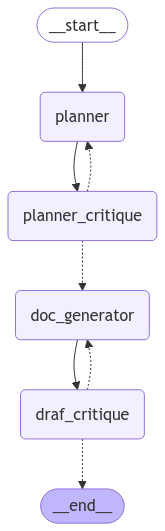

In [32]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
thread = {"configurable": {"thread_id": "1"}}

for s in graph.stream({
    'task': "Could you please generate a documentation for X3000 TurboFixer machine?"
}, thread):
    display_markdown(s)